In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import numpy as np


In [2]:
train_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/Skin Datasets/train'
validation_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/Skin Datasets/validate'
test_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/Skin Datasets/test'

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 5141 images belonging to 5 classes.


In [5]:
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 402 images belonging to 5 classes.


In [6]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 374 images belonging to 5 classes.


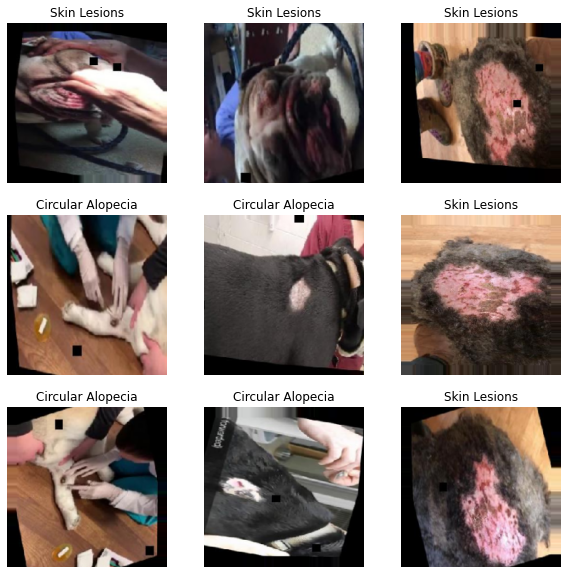

In [7]:
batch = train_generator.next()
images, labels = batch[0], batch[1]

label_names = ['Circular Alopecia', 'Flees', 'Healthy', 'RunLong', 'Skin Lesions']

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    
    label_index = np.argmax(labels[i])
    label = label_names[label_index]
    
    plt.title(label)
    plt.axis("off")
plt.show()


In [8]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [12]:
history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[early_stop])

Epoch 1/20
161/161 [==============================] - 54s 332ms/step - loss: 0.5349 - accuracy: 0.8041 - val_loss: 0.3384 - val_accuracy: 0.8682
Epoch 2/20
161/161 [==============================] - 44s 272ms/step - loss: 0.3764 - accuracy: 0.8566 - val_loss: 0.3335 - val_accuracy: 0.8781
Epoch 3/20
161/161 [==============================] - 40s 246ms/step - loss: 0.3204 - accuracy: 0.8800 - val_loss: 0.1788 - val_accuracy: 0.9527
Epoch 4/20
161/161 [==============================] - 42s 260ms/step - loss: 0.2814 - accuracy: 0.8948 - val_loss: 0.2510 - val_accuracy: 0.9154
Epoch 5/20
161/161 [==============================] - 42s 260ms/step - loss: 0.2521 - accuracy: 0.9088 - val_loss: 0.2125 - val_accuracy: 0.9328
Epoch 6/20
161/161 [==============================] - 43s 266ms/step - loss: 0.2276 - accuracy: 0.9140 - val_loss: 0.1864 - val_accuracy: 0.9428


In [13]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

12/12 [==============================] - 3s 231ms/step - loss: 0.2549 - accuracy: 0.9118
Test Accuracy: 0.9117646813392639


In [33]:
model.save('MobileNetV2_multi_Skin.h5')

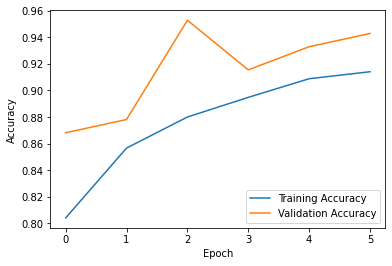

In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

12/12 [==============================] - 3s 225ms/step
Classification Report:
                  precision    recall  f1-score   support

circlar alopecia       0.93      0.99      0.96        86
           flees       1.00      0.25      0.40        16
         healthy       0.62      0.71      0.67        14
        runglong       0.93      0.90      0.91       157
    skin lesions       0.91      1.00      0.95       101

        accuracy                           0.91       374
       macro avg       0.88      0.77      0.78       374
    weighted avg       0.92      0.91      0.90       374



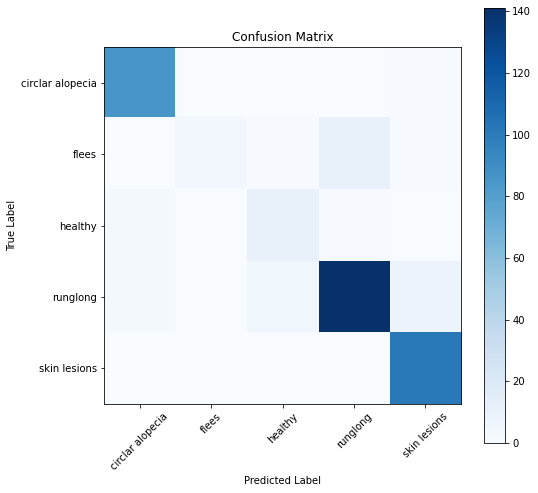

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
